In [1]:
from os import listdir, mkdir, remove
from os.path import isfile, join, isdir
import graph_tool.all as gt
import logging
import uuid
import copy
import json
import pickle
import networkx as nx
from GPR import GPR
from Rule import Rule, RHS, LHS
from karateclub import FeatherGraph, LDP

from Metrics import _dijkstra, MapLinearity, MissionLinearity,Leniency, PathRedundancy 
from Generator import Generator
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from sklearn.metrics import mean_squared_error, r2_score
from VertexProperty import VertexProperty
from RecipeEntry import RecipeEntry
import matplotlib.pyplot as plt
import heapq
import sys
import pandas as pd

In [2]:

labels_to_abbrevs = {
    "Start": "S",
    "Any": "A",
    "Lock": "Lo",
    "Normal": "N",
    "Lever": "Le",
    "Key": "K",
    "Puzzle": "P",
    "End": "E",
}

safe_rooms = ["S", "L", "Le", "K", "P", "E"]
# logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)


def makeGraph(lines):
    # g = gt.Graph(directed=False)
    g = gt.Graph()
    # g.vertex_properties["abbrevs"] = g.new_vertex_property("string")
    # g.vertex_properties["labels"] = g.new_vertex_property("string")
    # g.vertex_properties["terminality"] = g.new_vertex_property("bool")
    # g.vertex_properties["marks"] = g.new_vertex_property("string")
    # g.vertex_properties["access_level"] = g.new_vertex_property("string")
    g.vertex_properties["vertex_property"] = g.new_vertex_property("python::object")
    for line in lines:
        striped_line = line.strip()
        if striped_line == "nodes":
            is_node = True
            continue
        if striped_line == "edges":
            is_node = False
            continue
        components = striped_line.split(",")
        if is_node:
            label = components[2].strip()
            v = g.add_vertex()
            abbrev = labels_to_abbrevs[label]
            mark = components[3].strip()
            terminality = True
            if label == "Any":
                terminality = False
            g.vp.vertex_property[v] = VertexProperty(
                label, abbrev, terminality, mark, int(components[1])
            )
        else:
            u = components[0]
            v = components[1]
            g.add_edge(u, v)
    return g


directory = "../data/grammars/khalifa-grammar/"
onlydirs = [f for f in listdir(directory) if isdir(join(directory, f))]
rules = []
for folder in onlydirs:
    input_file_path = directory + folder + "/input.txt"
    input_file = open(input_file_path, "r")
    input_lines = input_file.readlines()
    output_file_path = directory + folder + "/output.txt"
    output_file = open(output_file_path, "r")
    output_lines = output_file.readlines()
    is_node = True
    lhs_graph = makeGraph(input_lines)
    lhs = LHS(lhs_graph)
    lhs_graph.vertex_properties["abbrevs"] = lhs_graph.new_vertex_property("string")
    for v in lhs_graph.vertices():
        lhs_graph.vp.abbrevs[v] = lhs_graph.vp.vertex_property[v].abbrev
    gt.graph_draw(
        lhs_graph,
        vertex_text=lhs_graph.vp.abbrevs,
        output="../data/imgs/" + folder + "-lhs.png",
    )
    rhs_graph = makeGraph(output_lines)
    rhs_graph.vertex_properties["abbrevs"] = rhs_graph.new_vertex_property("string")
    for v in lhs_graph.vertices():
        rhs_graph.vp.abbrevs[v] = rhs_graph.vp.vertex_property[v].abbrev
    gt.graph_draw(
        rhs_graph,
        vertex_text=rhs_graph.vp.abbrevs,
        output="../data/imgs/" + folder + "-rhs.png",
    )
    rhs = RHS(rhs_graph, 1)
    rule = Rule(folder, lhs, [rhs], 1)
    rules.append(rule)

axiom_path = directory + "graphStart.txt"
graph_file = open(axiom_path, "r")
axiom_lines = graph_file.readlines()
axiom = makeGraph(axiom_lines)

In [3]:
# logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
recipe = RecipeEntry.read_file(directory + "graphRecipe.txt")
gen = Generator(axiom, rules, "khalifa-grammar")
config = {"max_applications": 20, "sampling_method": "uniform"}
sample, sample_id = gen.applyRules(config)
# sample, sample_id = gen.applyRecipe(config, recipe)
sample.vertex_properties["abbrevs"] = sample.new_vertex_property("string")
for v in sample.vertices():
    sample.vp.abbrevs[v] = sample.vp.vertex_property[v].abbrev

In [4]:
MapLinearity(sample)
MissionLinearity(sample, 0, 1)
Leniency(sample,safe_rooms)
#PathRedundacy(graph)

0.782608695652174

In [5]:
leniency = []
map_linearity = []
mission_linearity = []
sample_ids = []
for i in range(1000):
    sample, sample_id = gen.applyRecipe(config, recipe)
    sample_ids.append(sample_id)
    leniency.append(Leniency(sample,safe_rooms))
    mission_linearity.append(MissionLinearity(sample,0,1))
    map_linearity.append(MapLinearity(sample))

data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity}
df = pd.DataFrame(data)
df

Sample ID  Leniency  Mission Linearity  \
0    685a241a-b4a0-46f6-88a5-222d457021d3  0.500000           0.428571   
1    57a059fd-c330-4372-ae3a-d2a86f64bf14  0.500000           0.500000   
2    327e92e8-7c49-4c75-a771-cec7eed013d3  0.500000           0.500000   
3    78f6a9b0-f48d-4323-9398-f4ac7182ffc1  0.416667           0.416667   
4    350aa36e-2951-40b4-8aa5-f2f7e8e9e53c  0.400000           0.500000   
..                                    ...       ...                ...   
995  fccd2285-8b98-4cef-bcac-66504da26a85  0.500000           0.500000   
996  54fb765d-3afc-41ab-a99c-f5d3edbd376e  0.416667           0.416667   
997  43f80941-c601-4505-b09c-614b35470810  0.400000           0.333333   
998  6fbd1189-704d-4213-94b9-220a4d940a19  0.500000           0.500000   
999  57db5c79-9c27-49f2-b6d5-617276c61f67  0.416667           0.416667   

     Map Linearity  
0         0.800000  
1         0.888889  
2         0.785714  
3         0.800000  
4         0.857143  
..             ...  
995       0.800000  
996       0.777778  
997       0.791667  
998       0.857143  
999       0.750000  

[1000 rows x 4 columns]

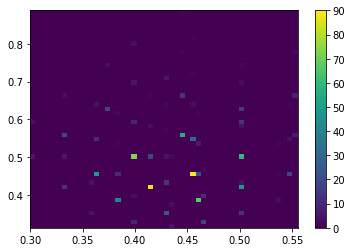

In [6]:
x = df["Leniency"]
y = df["Mission Linearity"]
plt.hist2d(x,y,bins=50)
plt.colorbar()
plt.show()

In [7]:
leniency = []
map_linearity = []
mission_linearity = []
sample_ids = []
for i in range(100):
    sample, sample_id = gen.applyRules(config)
    sample_ids.append(sample_id)
    leniency.append(Leniency(sample,safe_rooms))
    mission_linearity.append(MissionLinearity(sample,0,1))
    map_linearity.append(MapLinearity(sample))

data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity}
df = pd.DataFrame(data)
df

RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
x = df["Leniency"]
y = df["Mission Linearity"]
plt.hist2d(x,y,bins=50)
plt.colorbar()
plt.show()